# Importing Libraries

In [137]:
!pip install xgboost


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
import copy
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import mean_squared_error as mse
from utility import *
from sklearn.model_selection import cross_val_score

## Importing the Data
1. TrainData - Original
2. TestData - testDf

In [139]:
original = pd.read_csv("./titanic/train.csv")
testDf = pd.read_csv("./titanic/test.csv")
test = copy.deepcopy(testDf)
df = copy.deepcopy(original)

## Exploratory Data Analysis
Types of Data:
1. Continuous Data
   1. Age
   2. Fare
2. Discrete Data
   1. Survived
   2. SibSp
   3. Parch
   4. PassengerId
3. Categorical Data
   1. Name
   2. Pclass
   3. Cabin
   4. Embarked
   5. Sex
   6. Ticket

![image.png](attachment:330bac07-c0a3-4fb3-a616-b64a7d6617eb.png)
![image.png](attachment:35db6205-e342-429d-8b0e-53b2c388c43c.png)
![image.png](attachment:c8eb2c98-3a62-4045-b958-318db589c437.png)

## Handling Missing Values
1. Cabin
2. Embarked
3. Age

In [140]:
# Processing the Data to remove columns with >= 50% missing values and removing rows forming <= 5% missing values.
# Dropping highly variable columns of Ticket, Name, PassengerId
# Factorizing the remaining categorical data - LabelEncoder
# This data point in Fare was missing, instead of making a whole model to impute the value, I replaced it with mode
test.loc[test['Fare'].isna(), 'Fare'] = 7.812
df = process_data(df)
# Using Linear Regression to impute Ages.
X_train, Y_train, X_test = create_splits(df.drop('Survived', axis = 1), "Age")
# Better if we dont exclude Survived, but had to do for testData
model = train_model(X_train, Y_train)
df = impute_age(df, "Age", X_test, model)
test = process_data(test)
X_train, Y_train, X_test = create_splits(test, "Age")
test = impute_age(test, "Age", X_test, model)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 140
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 6
[LightGBM] [Info] Start training from score 29.642093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

## Handling Duplicates

In [141]:
df = remove_duplicates(df)

## Outlier Detection
1. Univariate Outliers
2. Multivariate Outliers

SibSp Value Count:  SibSp
0    505
1    201
2     27
4     18
3     14
5      5
8      2
Name: count, dtype: int64
Parch Value Count:  Parch
0    568
1    114
2     75
5      5
3      5
4      4
6      1
Name: count, dtype: int64


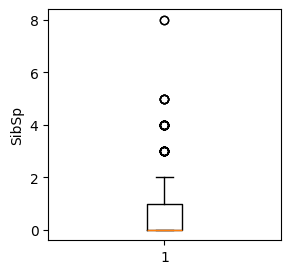

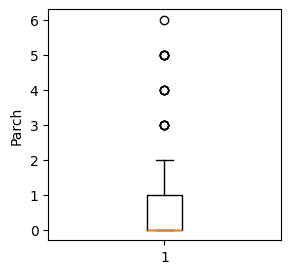

SibSp  : 


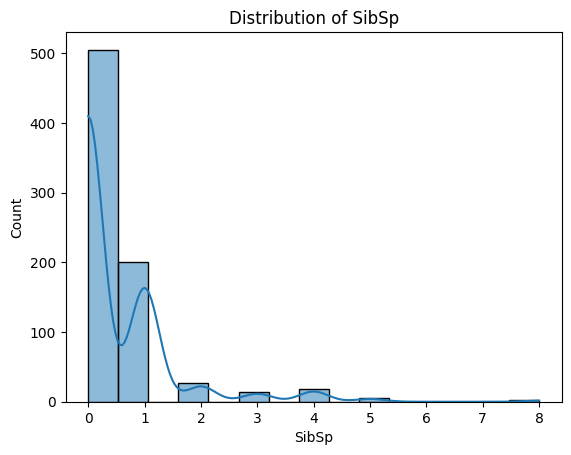

Parch  : 


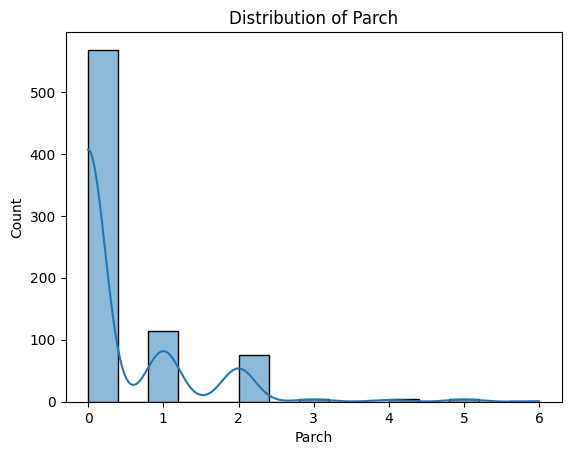

In [142]:
# SibSp and Parch are discrete, so we can also cap them or remove them to certain level.. I am using Percentiles to cap according to my domain knowledge
# The Data is highly skewed, therefore, IQR method will not work on it. As we cannot numericalize it. So we will go with Percentiles
cols = ['SibSp', "Parch"]
print('SibSp Value Count: ', df['SibSp'].value_counts())
print('Parch Value Count: ', df['Parch'].value_counts())
box_plot(df, cols)
dist_plot(df, cols)

SibSp Value Count:  SibSp
0    505
1    201
2     27
4     18
3     14
5      5
8      2
Name: count, dtype: int64
Parch Value Count:  Parch
0    568
1    114
2     75
5      5
3      5
4      4
6      1
Name: count, dtype: int64


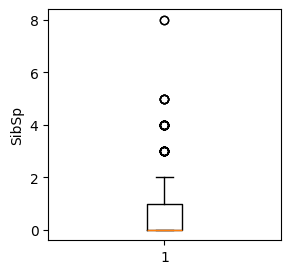

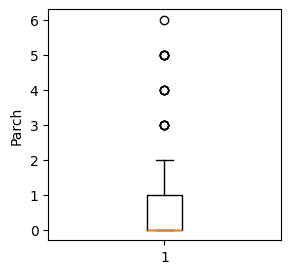

SibSp  : 


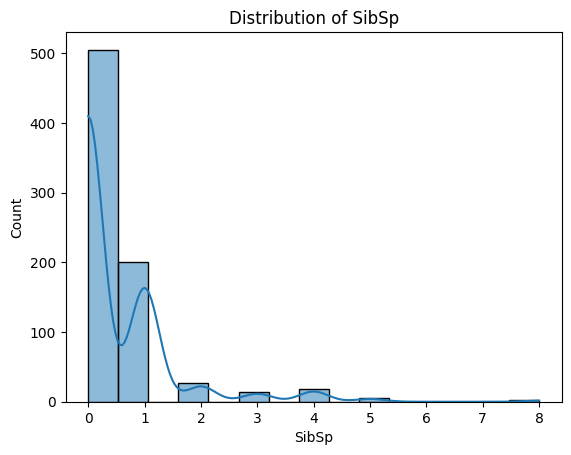

Parch  : 


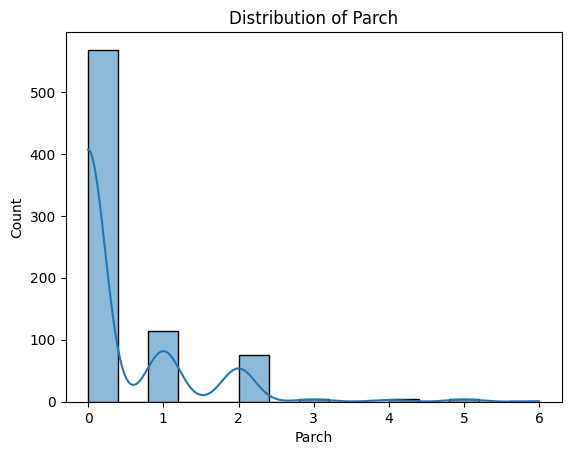

In [143]:
# SibSp and Parch are discrete, so we can also cap them or remove them to certain level.. I am using Percentiles to cap according to my domain knowledge
# The Data is highly skewed, therefore, IQR method will not work on it. As we cannot numericalize it. So we will go with Percentiles
cols = ['SibSp', "Parch"]
print('SibSp Value Count: ', df['SibSp'].value_counts())
print('Parch Value Count: ', df['Parch'].value_counts())
box_plot(df, cols)
dist_plot(df, cols)

In [144]:
# According to me, the SibSp can be capped at 97.5 percentile
upper_limit = np.percentile(df['SibSp'], 97.5)
print("Upper Limit for SibSp: ", upper_limit)
valuesToBeCapped = np.where(df["SibSp"] > upper_limit)[0]
df.loc[valuesToBeCapped, "SibSp"] = 4

Upper Limit for SibSp:  4.0


In [145]:
# Same thing for Parch
# According to my knowledge, best answer was 4 after deeply analyzing the data and seeing the graphs
upper_limit = np.percentile(df['Parch'], 98.5)
print("Upper Limit for Parch: ", upper_limit)
valuesToBeCapped = np.where(df["Parch"]>upper_limit)[0]
df.loc[valuesToBeCapped, "Parch"] = 4


Upper Limit for Parch:  3.0


### Continuous Data

c:\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


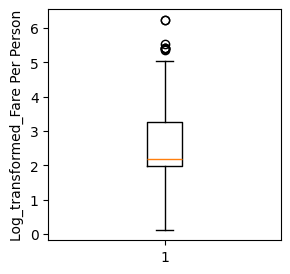

Log_transformed_Fare Per Person  : 


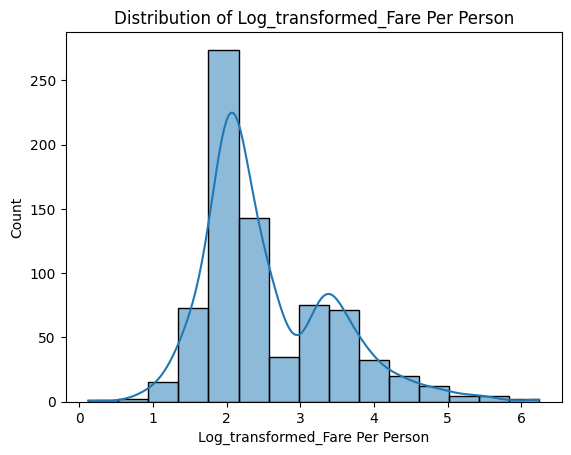

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Fare Per Person,Log_transformed_Fare Per Person
0,0,3,0,22.0,1,0,7.2500,0,3.62500,1.287854
1,1,1,1,38.0,1,0,71.2833,1,35.64165,3.573515
2,1,3,1,26.0,0,0,7.9250,0,7.92500,2.070022
3,1,1,1,35.0,1,0,53.1000,0,26.55000,3.279030
4,0,3,0,35.0,0,0,8.0500,0,8.05000,2.085672


In [146]:
# I created another feature to get better idea, and applied log to normalize the data as the data for fare was also skewed, in order to perform IQR
# I transformed into log data.
df['Fare Per Person'] = df["Fare"]/(df["SibSp"]+df['Parch'] + 1)
df = transform_log(df, 'Fare Per Person')
col = ['Log_transformed_Fare Per Person']
box_plot(df, col)
dist_plot(df, col)
col = 'Log_transformed_Fare Per Person'
lower_limit, upper_limit = calc_iqr(df, col)
data = copy.deepcopy(df)
data = data[(data[col] < upper_limit)]
# 4 is the most suitable lowerLimit after analyzing the data
data = data[data['Fare'] >= 4]
data.reset_index(drop = True, inplace = True)
data.head()

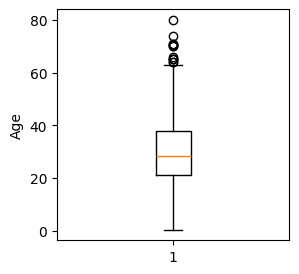

Upper Limit for Age: 63.5


In [147]:
col = ['Age']
box_plot(data, col)
stanD = data['Age'].std()
meanD = data['Age'].mean()
cappedValue = meanD + 3*stanD
lower_limit, upper_limit = calc_iqr(data, "Age")
print("Upper Limit for Age:", upper_limit)
valuesToBeCapped = np.where(data[col] > 65)[0]
data.loc[valuesToBeCapped, "Age"] = cappedValue

## We are done with univariate, now its time for multivariate Outliers.
I have used Isolation Forest, but have to preprocess as it only accepts numerical data. I have not used other techniques such as Mahalanobis Distance because it requires normal distribution data

In [148]:
# One Hot Encoding for Gender and Cities
new_data = copy.deepcopy(data)
new_data
new_data = pd.get_dummies(new_data, columns= ["Embarked", "Sex"])
new_data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Fare Per Person,Log_transformed_Fare Per Person,Embarked_0,Embarked_1,Embarked_2,Sex_0,Sex_1
0,0,3,22.0,1,0,7.2500,3.62500,1.287854,True,False,False,True,False
1,1,1,38.0,1,0,71.2833,35.64165,3.573515,False,True,False,False,True
2,1,3,26.0,0,0,7.9250,7.92500,2.070022,True,False,False,False,True
3,1,1,35.0,1,0,53.1000,26.55000,3.279030,True,False,False,False,True
4,0,3,35.0,0,0,8.0500,8.05000,2.085672,True,False,False,True,False


In [149]:
# Converting into Normal Data. And removing Log data as I dont want them to be part
new_data = new_data.replace({True: 1, False: 0})
new_data['Pclass'] = new_data['Pclass'].replace({3: 1, 1:3})
cols = [col for col in new_data.columns if "Log" in col]
print(cols)
new_data.drop(cols, axis = 1, inplace = True)
new_data.head()

['Log_transformed_Fare Per Person']


C:\Users\786\AppData\Local\Temp\ipykernel_18904\3102651630.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  new_data = new_data.replace({True: 1, False: 0})


,Survived,Pclass,Age,SibSp,Parch,Fare,Fare Per Person,Embarked_0,Embarked_1,Embarked_2,Sex_0,Sex_1
0,0,1,22.0,1,0,7.2500,3.62500,1,0,0,1,0
1,1,3,38.0,1,0,71.2833,35.64165,0,1,0,0,1
2,1,1,26.0,0,0,7.9250,7.92500,1,0,0,0,1
3,1,3,35.0,1,0,53.1000,26.55000,1,0,0,0,1
4,0,1,35.0,0,0,8.0500,8.05000,1,0,0,1,0


In [150]:
# Multivariate Outliers
anomaly_data = copy.deepcopy(new_data)
model = IsolationForest(n_estimators= 100, contamination=0.015, random_state=42)
model.fit(anomaly_data)
new_data['Anomaly Score'] = model.decision_function(anomaly_data)
new_data["Anomaly"] = model.predict(anomaly_data)
new_data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Fare Per Person,Embarked_0,Embarked_1,Embarked_2,Sex_0,Sex_1,Anomaly Score,Anomaly
0,0,1,22.0,1,0,7.2500,3.62500,1,0,0,1,0,0.221171,1
1,1,3,38.0,1,0,71.2833,35.64165,0,1,0,0,1,0.117919,1
2,1,1,26.0,0,0,7.9250,7.92500,1,0,0,0,1,0.199188,1
3,1,3,35.0,1,0,53.1000,26.55000,1,0,0,0,1,0.176356,1
4,0,1,35.0,0,0,8.0500,8.05000,1,0,0,1,0,0.268236,1


In [151]:
# Removing those outliers as they are multivariate and it will be difficult to adjust them again and reversing the one hot encoding
# as it is not needed now.
new_data = new_data[new_data["Anomaly"] != -1]
new_data.reset_index(drop = True, inplace= True)
cols = ["Sex", "Embarked"]
reverse_one_hot(new_data, cols)
new_data.head()

['Sex_0', 'Sex_1']
['Embarked_0', 'Embarked_1', 'Embarked_2']


,Survived,Pclass,Age,SibSp,Parch,Fare,Fare Per Person,Anomaly Score,Anomaly,Sex,Embarked
0,0,1,22.0,1,0,7.2500,3.62500,0.221171,1,0,0
1,1,3,38.0,1,0,71.2833,35.64165,0.117919,1,1,1
2,1,1,26.0,0,0,7.9250,7.92500,0.199188,1,1,0
3,1,3,35.0,1,0,53.1000,26.55000,0.176356,1,1,0
4,0,1,35.0,0,0,8.0500,8.05000,0.268236,1,0,0


In [152]:
# Removing them
cols = ['Anomaly Score', "Anomaly"]
new_data.drop(cols, inplace = True, axis = 1)
new_data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Fare Per Person,Sex,Embarked
0,0,1,22.0,1,0,7.2500,3.62500,0,0
1,1,3,38.0,1,0,71.2833,35.64165,1,1
2,1,1,26.0,0,0,7.9250,7.92500,1,0
3,1,3,35.0,1,0,53.1000,26.55000,1,0
4,0,1,35.0,0,0,8.0500,8.05000,0,0


## Feature Analysis Feature Selection
I am going to use Partial, Complete Corelation and Mutual Information to find the most effective features for my dataset


In [153]:
new_data = transform_log(new_data, "Fare Per Person")
analyzed_data = copy.deepcopy(new_data)
pcCorr = compute_partial_relation(analyzed_data, "Survived")
print(analyzed_data.dtypes)

Pclass:
           n         r        CI95%         p-val
pearson  743  0.337535  [0.27, 0.4]  2.958340e-21
Age:
           n         r           CI95%     p-val
pearson  743 -0.088913  [-0.16, -0.02]  0.015338
SibSp:
           n         r          CI95%     p-val
pearson  743 -0.033409  [-0.11, 0.04]  0.363141
Parch:
           n        r         CI95%     p-val
pearson  743  0.09081  [0.02, 0.16]  0.013277
Fare:
           n         r         CI95%         p-val
pearson  743  0.289502  [0.22, 0.35]  8.212193e-16
Fare Per Person:
           n         r         CI95%         p-val
pearson  743  0.257955  [0.19, 0.32]  9.285011e-13
Sex:
           n         r         CI95%         p-val
pearson  743  0.502533  [0.45, 0.55]  8.481193e-49
Embarked:
           n         r          CI95%     p-val
pearson  743  0.065038  [-0.01, 0.14]  0.076443
Log_transformed_Fare Per Person:
           n         r         CI95%         p-val
pearson  743  0.262808  [0.19, 0.33]  3.340066e-13
Survived    

In [154]:
# Using MI - Discretizing as MI works good on discrete data
cols = ["Fare", "Log_transformed_Fare Per Person", "Age"]
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
analyzed_data[cols] = discretizer.fit_transform(analyzed_data[cols])
mi_scores = mutual_info_classif(analyzed_data.drop("Survived", axis = 1), analyzed_data["Survived"], random_state=42)
mi_df = pd.DataFrame({'Feature': analyzed_data.drop("Survived", axis = 1).columns, 'MI Score': mi_scores})
print(mi_df)

                           Feature  MI Score
0                           Pclass  0.045021
1                              Age  0.012966
2                            SibSp  0.000426
3                            Parch  0.000000
4                             Fare  0.054546
5                  Fare Per Person  0.107671
6                              Sex  0.107122
7                         Embarked  0.001267
8  Log_transformed_Fare Per Person  0.056204


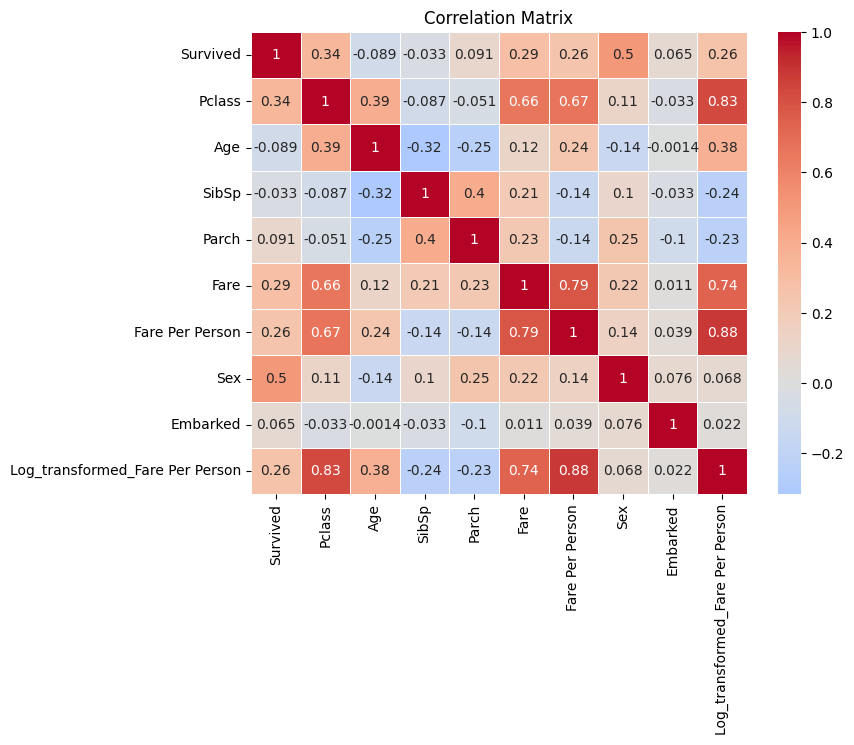

In [155]:
corrFull = new_data.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corrFull, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

### Notes
I have removed Fare Per Person and SibSp for better results and added Log Fare Per Person along with Total People that accounts for SibSp.
I am going to remove SibSp, and Fare per person as SibSp p value was against it and i think log will perform better as its results were more statistically significant

In [156]:
new_data['Total People'] = new_data["Parch"] + new_data["SibSp"] + 1
test['Total People'] = test['Parch'] + test['SibSp'] + 1
test['Fare Per Person'] = test["Fare"]/(test["SibSp"]+test['Parch'] + 1)
test = transform_log(test, 'Fare Per Person')
new_data.drop(inplace=True, axis = 0, columns = ['Fare Per Person', 'SibSp'])

c:\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [157]:
new_data.head()

,Survived,Pclass,Age,Parch,Fare,Sex,Embarked,Log_transformed_Fare Per Person,Total People
0,0,1,22.0,0,7.2500,0,0,1.287854,2
1,1,3,38.0,0,71.2833,1,1,3.573515,2
2,1,1,26.0,0,7.9250,1,0,2.070022,1
3,1,3,35.0,0,53.1000,1,0,3.279030,2
4,0,1,35.0,0,8.0500,0,0,2.085672,1


## Final Touches

In [158]:
# Encoding
cols = ["Sex", "Embarked"]
encoded_data = pd.get_dummies(data = new_data, columns = cols)
encoded_data = encoded_data.replace({True: 1, False: 0})
encoded_data = encoded_data[sorted(encoded_data)]
encoded_data.head()

C:\Users\786\AppData\Local\Temp\ipykernel_18904\1681472905.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  encoded_data = encoded_data.replace({True: 1, False: 0})


,Age,Embarked_0,Embarked_1,Embarked_2,Fare,Log_transformed_Fare Per Person,Parch,Pclass,Sex_0,Sex_1,Survived,Total People
0,22.0,1,0,0,7.2500,1.287854,0,1,1,0,0,2
1,38.0,0,1,0,71.2833,3.573515,0,3,0,1,1,2
2,26.0,1,0,0,7.9250,2.070022,0,1,0,1,1,1
3,35.0,1,0,0,53.1000,3.279030,0,3,0,1,1,2
4,35.0,1,0,0,8.0500,2.085672,0,1,1,0,0,1


In [159]:
X_train.columns.size

6

In [160]:
X_train = encoded_data.drop("Survived", axis = 1)
Y_train = encoded_data['Survived']
model = RandomForestClassifier(n_jobs = -1,  max_depth = 4, n_estimators=50)
model.fit(X_train, Y_train)
y_train = model.predict(X_train)
cv_scores = cross_val_score(model, X_train, Y_train, cv=5, scoring='accuracy')

In [161]:
X_train

,Age,Embarked_0,Embarked_1,Embarked_2,Fare,Log_transformed_Fare Per Person,Parch,Pclass,Sex_0,Sex_1,Total People
0,22.0,1,0,0,7.2500,1.287854,0,1,1,0,2
1,38.0,0,1,0,71.2833,3.573515,0,3,0,1,2
2,26.0,1,0,0,7.9250,2.070022,0,1,0,1,1
3,35.0,1,0,0,53.1000,3.279030,0,3,0,1,2
4,35.0,1,0,0,8.0500,2.085672,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
738,28.0,1,0,0,10.5000,2.351375,0,2,1,0,1
739,19.0,1,0,0,30.0000,3.401197,0,3,0,1,1
740,27.0,1,0,0,23.4500,1.768576,2,1,0,1,4
741,26.0,0,1,0,30.0000,3.401197,0,3,1,0,1


In [162]:
print("Cross-Validation Accuracy:", np.mean(cv_scores))
print("NICE")

Cross-Validation Accuracy: 0.7766279702521314
NICE


In [163]:
test = test.replace({-np.inf:0})
test.drop(inplace=True, axis = 0, columns = ['Fare Per Person', 'SibSp'])
test = test.replace({True: 1, False: 0})
test['Pclass'] = test['Pclass'].replace({3: 1, 1:3})
cols = ["Sex", "Embarked"]
encoded_data_test = pd.get_dummies(data = test, columns = cols)
X_test = encoded_data_test[sorted(encoded_data_test)]
X_test

,Age,Embarked_0,Embarked_1,Embarked_2,Fare,Log_transformed_Fare Per Person,Parch,Pclass,Sex_0,Sex_1,Total People
0,34.5,True,False,False,7.8292,2.057860,0,1,True,False,1
1,47.0,False,True,False,7.0000,1.252763,0,1,False,True,2
2,62.0,True,False,False,9.6875,2.270836,0,2,True,False,1
3,27.0,False,True,False,8.6625,2.159003,0,1,True,False,1
4,22.0,False,True,False,12.2875,1.409970,1,1,False,True,3
...,...,...,...,...,...,...,...,...,...,...,...
413,28.0,False,True,False,8.0500,2.085672,0,1,True,False,1
414,39.0,False,False,True,108.9000,4.690430,0,3,False,True,1
415,38.5,False,True,False,7.2500,1.981001,0,1,True,False,1
416,28.0,False,True,False,8.0500,2.085672,0,1,True,False,1


In [164]:
y_test = model.predict(X_test)


In [165]:
np.savetxt('arrayFinal1.csv', y_test, delimiter=',', fmt='%d')


In [166]:
y_test = pd.DataFrame(y_test)

In [167]:
testResult = pd.read_csv('./titanic/gender_submission.csv')

In [168]:
testResult['Survived'] = y_test

In [169]:
testResult.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [170]:
testResult.to_csv('Submission_file_nameRandom2.csv', index=False , header = 1)
#